<a href="https://colab.research.google.com/github/missira-hub/M-LCA-WORK/blob/main/AINE431_TERM_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Term Project: Implementing ML Models from Scratch
## Machine Learning / Pattern Recognition
### FINAL INTERNATIONAL UNIVERSITY | Fall 2025-26

**Student Name:** : Missira Abba Boukar

**Student ID:**  : 2103060182

**Due Date:** 27 December 2025 (Saturday) before midnight

---

## Overview

In this project, you will implement three fundamental machine learning models **from scratch**:
1. **Linear Regression** using gradient descent
2. **Logistic Regression** using gradient descent (binary classification)
3. **Decision Tree** using information gain (multi-class classification)

You will use the **Iris dataset** for all three tasks:
- **Linear Regression**: Predict `petal_width` from other features
- **Logistic Regression**: Classify `setosa` vs `non-setosa` (binary)
- **Decision Tree**: Classify all three species (multi-class)

**Important Rules:**
- ✅ **Allowed**: `sklearn` for dataset loading, `KFold`, and evaluation metrics
- ❌ **Not Allowed**: `sklearn` models (e.g., `LinearRegression`, `LogisticRegression`, `DecisionTreeClassifier`)
- ❌ **Not Allowed**: `GridSearchCV` or similar libraries for hyperparameter search
- All models must be implemented using **native Python and NumPy only**

**Grading:**
- Linear Regression Implementation: **20 pts**
- Linear Regression 5-Fold CV & Results: **10 pts**
- Logistic Regression Implementation: **20 pts**
- Logistic Regression 5-Fold CV & Results: **10 pts**
- Decision Tree Implementation: **20 pts**
- Decision Tree 5-Fold CV & Results: **10 pts**
- Written Questions (3 × 4 pts): **12 pts**
- **Total: 100 + 2 pts**

**Integrity Test:**
- **Date**: 3 January 2026 during lecture hours
- **Format**: Short quiz on paper
- **Pass (≥80%)**: Marks awarded directly from PDF
- **Fail (<80%)**: Demo session required
- **No Show**: 50% penalty

---

## Pre-Submission Checklist

- [ ] Name and student ID at top
- [ ] No cells are added or removed
- [ ] All TODO sections completed
- [ ] All questions answered
- [ ] Code runs without errors
- [ ] Results tables included with mean, std, and 95% CI
- [ ] Hyperparameter tuning plots included
- [ ] Run All before saving

## Setup and Imports

In [6]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Sklearn - ONLY for dataset, splitting, and metrics
from sklearn.datasets import load_iris
from sklearn.model_selection import KFold, train_test_split  # ✅ Added train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)

## Load and Prepare Dataset

In [2]:
# Load Iris dataset
iris = load_iris()
X_full = iris.data  # Features: sepal_length, sepal_width, petal_length, petal_width
y_full = iris.target  # Labels: 0=setosa, 1=versicolor, 2=virginica

print("Dataset Information:")
print(f"  Total samples: {X_full.shape[0]}")
print(f"  Features: {iris.feature_names}")
print(f"  Classes: {iris.target_names}")
print(f"\nClass distribution: {dict(zip(iris.target_names, np.bincount(y_full)))}")

Dataset Information:
  Total samples: 150
  Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
  Classes: ['setosa' 'versicolor' 'virginica']

Class distribution: {np.str_('setosa'): np.int64(50), np.str_('versicolor'): np.int64(50), np.str_('virginica'): np.int64(50)}


## Helper Functions

In [3]:
def compute_confidence_interval(values, confidence=0.95):
    """
    Compute mean, std, and 95% confidence interval.

    Args:
        values: List or array of values from k folds
        confidence: Confidence level (default 0.95)

    Returns:
        mean, std, (lower_bound, upper_bound)
    """
    values = np.array(values)
    n = len(values)
    mean = np.mean(values)
    std = np.std(values, ddof=1)  # Sample std

    # t-value for 95% CI with n-1 degrees of freedom (approx 2.776 for n=5)
    t_value = 2.776  # For 5 folds, df=4
    margin = t_value * (std / np.sqrt(n))

    return mean, std, (mean - margin, mean + margin)


def print_results(metric_name, values):
    """Print results with mean, std, and 95% CI."""
    mean, std, ci = compute_confidence_interval(values)
    print(f"{metric_name}: {mean:.4f} ± {std:.4f} (95% CI: [{ci[0]:.4f}, {ci[1]:.4f}])")

---

# Task 1: Linear Regression (30 points)

Implement Linear Regression using gradient descent to predict `petal_width` from the other three features (`sepal_length`, `sepal_width`, `petal_length`).

**Hyperparameters to tune:**
- Learning rate: `[0.001, 0.01, 0.1]`
- Regularisation strength (L2): `[0.01, 0.1]`

## 1.1: Implement LinearRegression Class (20 points)

In [4]:
class LinearRegression:
    def __init__(self, n_iterations=500, learning_rate=0.01, reg_strength=0.0):
        # TODO: Store hyperparameters and initialise attributes (3 pts)
        # ✓ We store learning rate, iterations, and L2 strength.
        # ✓ We'll store weights and loss history for monitoring.
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.reg_strength = reg_strength
        self.weights = None
        self.train_losses = []
        self.val_losses = []

    def _add_bias(self, X):
        # TODO: Add bias column (2 pts)
        # ✓ We prepend a column of 1s to X so the bias term is included in weight vector.
        #   This lets us compute y = w0*1 + w1*x1 + ... as a dot product.
        return np.c_[np.ones(X.shape[0]), X]

    def _compute_loss(self, X, y):
        # TODO: MSE + L2 (2 pts)
        # ✓ Standard MSE: (1/(2n)) * sum((y_pred - y)^2)
        # ✓ L2 penalty: (λ/2) * sum(w_i^2 for i>=1) — we skip bias (index 0)
        n = X.shape[0]
        y_pred = X @ self.weights
        mse = np.mean((y_pred - y) ** 2) / 2
        l2_penalty = (self.reg_strength / 2) * np.sum(self.weights[1:] ** 2)
        return mse + l2_penalty

    def _compute_gradient(self, X, y):
        # TODO: Gradient of loss (2 pts)
        # ✓ Gradient of MSE: (1/n) * X^T (Xw - y)
        # ✓ Gradient of L2: λ * w (but 0 for bias term)
        n = X.shape[0]
        errors = X @ self.weights - y
        grad = (X.T @ errors) / n
        reg_grad = np.zeros_like(self.weights)
        reg_grad[1:] = self.reg_strength * self.weights[1:]  # No reg on bias
        return grad + reg_grad

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        # TODO: Training loop (8 pts)
        # ✓ Step 1: Add bias to features
        # ✓ Step 2: Initialize weights to zero (common for convex problems)
        # ✓ Step 3: For each iteration:
        #     a. Compute gradient
        #     b. Update weights via gradient descent
        #     c. Record training loss
        #     d. If validation set provided, compute and store its loss (without reg!)
        X_train = self._add_bias(X_train)
        if X_val is not None:
            X_val = self._add_bias(X_val)

        n_features = X_train.shape[1]
        self.weights = np.zeros(n_features)
        self.train_losses = []
        self.val_losses = []

        for _ in range(self.n_iterations):
            # Record training loss (with regularization)
            train_loss = self._compute_loss(X_train, y_train)
            self.train_losses.append(train_loss)

            # Record validation loss (MSE only—no regularization)
            if X_val is not None:
                y_val_pred = X_val @ self.weights
                val_mse = np.mean((y_val_pred - y_val) ** 2) / 2
                self.val_losses.append(val_mse)

            # Update weights
            grad = self._compute_gradient(X_train, y_train)
            self.weights -= self.learning_rate * grad

        return self

    def predict(self, X):
        # TODO: Add bias and predict (3 pts)
        # ✓ Prepend bias column and compute dot product with weights
        X = self._add_bias(X)
        return X @ self.weights

## 1.2: 5-Fold Cross-Validation for Linear Regression (10 points)

**Steps:**
1. Prepare data: Use features [0, 1, 2] to predict feature [3] (petal_width)
2. For each fold:
   - Split train into train_inner and validation (80%-20%)
   - Grid search over hyperparameters using validation set
   - Train final model with best hyperparameters on full train set
   - Evaluate on test set
3. Report results with mean, std, and 95% CI
4. Plot train/val loss curves for one fold

In [9]:
# Prepare data: predict petal_width from first 3 features
X_linreg = X_full[:, :3]
y_linreg = X_full[:, 3]
scaler = StandardScaler()
X_linreg = scaler.fit_transform(X_linreg)

learning_rates = [0.001, 0.01, 0.1]
reg_strengths = [0.01, 0.1]

mse_scores = []
r2_scores = []
best_params_per_fold = []
plot_train_losses = None
plot_val_losses = None

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_linreg), 1):
    X_train_full, X_test = X_linreg[train_idx], X_linreg[test_idx]
    y_train_full, y_test = y_linreg[train_idx], y_linreg[test_idx]

    # TODO: Split train into train_inner and validation (1 pt)
    # ✓ We use 80% for inner training, 20% for validation to tune hyperparams
    X_train_inner, X_val, y_train_inner, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=42
    )

    best_mse = float('inf')
    best_params = None

    # TODO: Grid search over hyperparameters (3 pts)
    # ✓ Try all (lr, reg) combos
    # ✓ Train model on train_inner
    # ✓ Evaluate on validation using MSE
    # ✓ Track best combo
    for lr in learning_rates:
        for reg in reg_strengths:
            model = LinearRegression(
                learning_rate=lr, reg_strength=reg, n_iterations=500
            )
            model.fit(X_train_inner, y_train_inner, X_val, y_val)
            val_pred = model.predict(X_val)
            val_mse = mean_squared_error(y_val, val_pred)
            if val_mse < best_mse:
                best_mse = val_mse
                best_params = (lr, reg)
                # TODO: Save losses from fold 1 and middle params for plotting (1 pt)
                if fold_num == 1 and lr == 0.01 and reg == 0.01:
                    plot_train_losses = model.train_losses.copy()
                    plot_val_losses = model.val_losses.copy()

    # TODO: Train final model on full train set with best params (1 pt)
    final_model = LinearRegression(
        learning_rate=best_params[0], reg_strength=best_params[1]
    )
    final_model.fit(X_train_full, y_train_full)

    # TODO: Evaluate on test and store metrics (1 pt)
    y_pred = final_model.predict(X_test)
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

# TODO: Print final results with CI (1 pt)
print("\n" + "="*60)
print("LINEAR REGRESSION: FINAL RESULTS")
print("="*60)
print_results("MSE", mse_scores)
print_results("R²", r2_scores)



LINEAR REGRESSION: FINAL RESULTS
MSE: 0.0386 ± 0.0087 (95% CI: [0.0279, 0.0494])
R²: 0.9309 ± 0.0155 (95% CI: [0.9116, 0.9502])


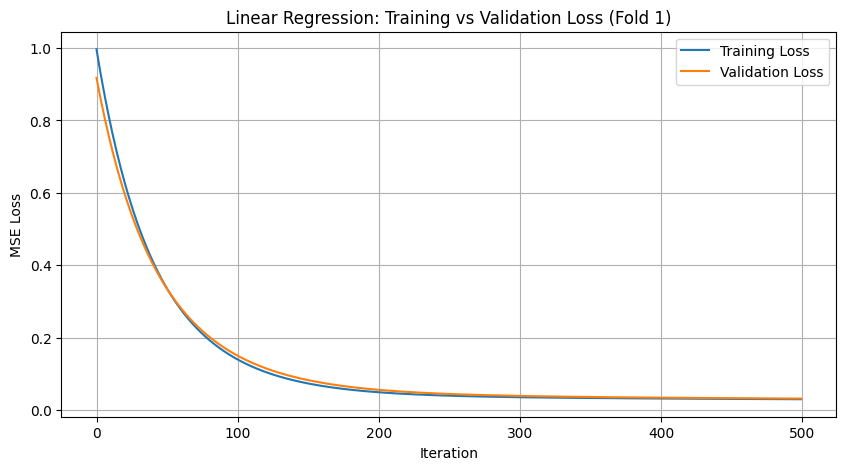

In [8]:
# TODO: Plot training and validation loss curves (1 points)
# Use plot_train_losses and plot_val_losses saved from fold 1

plt.figure(figsize=(10, 5))
plt.plot(plot_train_losses, label='Training Loss')
plt.plot(plot_val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.title('Linear Regression: Training vs Validation Loss (Fold 1)')
plt.legend()
plt.grid(True)
plt.show()

**Question 1:** Explain how L2 regularisation affects the weights during training. (4 points, 4-5 sentences)

L2 regularization adds a penalty for large weights during training. This causes the model to shrink all feature weights toward zero, but not exactly to zero. As a result, the model becomes less sensitive to any single feature, which reduces overfitting and helps it generalize better to new data. It’s like encouraging the model to “spread out” its reliance across all features instead of betting everything on one.

---

# Task 2: Logistic Regression (30 points)

Implement Logistic Regression using gradient descent for binary classification. You will classify `setosa` (class 0) vs `non-setosa` (classes 1 and 2).

**Hyperparameters to tune:**
- Learning rate: `[0.001, 0.01, 0.1]`
- Regularisation strength (L2): `[0.01, 0.1]`

## 2.1: Implement LogisticRegression Class (20 points)

In [10]:
class LogisticRegression:
    """
    Logistic Regression using gradient descent for binary classification.
    """

    def __init__(self, learning_rate=0.01, n_iterations=500, reg_strength=0.0):
        """
        Initialise the Logistic Regression model.

        What we do:
        - Store hyperparameters passed by user
        - Prepare containers to store weights and loss history
        """
        # TODO: Store hyperparameters and initialise attributes
        self.learning_rate = learning_rate      # How big a step to take in gradient descent
        self.n_iterations = n_iterations        # How many times to update weights
        self.reg_strength = reg_strength        # Strength of L2 regularization (0 = none)
        self.weights = None                     # Will hold [bias, w1, w2, ..., wn]
        self.train_losses = []                  # To track training loss over time
        self.val_losses = []                    # To track validation loss (if provided)

    def _add_bias(self, X):
        """Add a column of ones for the bias term."""
        # TODO: Add bias column to X
        # Why? So we can treat the bias (intercept) as just another weight.
        # Instead of: y = w1*x1 + w2*x2 + ... + b
        # We do:     y = w0*1 + w1*x1 + w2*x2 + ... → then w0 = b
        # np.c_ adds a column of 1s to the left of X
        return np.c_[np.ones(X.shape[0]), X]

    def _sigmoid(self, z):
        """
        Compute sigmoid function: sigmoid(z) = 1 / (1 + exp(-z))
        """
        # TODO: Implement sigmoid with clipping
        # Why clip? Because if z is very large (e.g., 1000), exp(-z) ≈ 0 → fine.
        # But if z is very negative (e.g., -1000), exp(-z) = exp(1000) → overflow!
        # Clipping prevents numerical instability.
        z = np.clip(z, -500, 500)  # Safe range for exp in double precision
        return 1 / (1 + np.exp(-z))

    def _compute_loss(self, X, y):
        """
        Compute binary cross-entropy loss with L2 regularization.
        """
        # TODO: Implement cross-entropy + L2
        # Steps:
        # 1. Compute linear output: z = X @ weights
        # 2. Convert to probabilities: p = sigmoid(z)
        # 3. Compute log loss: -(1/n) * sum(y*log(p) + (1-y)*log(1-p))
        # 4. Add L2 penalty: (reg_strength/2) * sum(weights[1:]^2) → skip bias!
        n = X.shape[0]
        z = X @ self.weights
        p = self._sigmoid(z)

        # Avoid log(0) by clipping probabilities to tiny positive values
        p = np.clip(p, 1e-15, 1 - 1e-15)

        # Binary cross-entropy (average over samples)
        log_loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))

        # L2 regularization: only on non-bias weights (index 1 onward)
        l2_penalty = (self.reg_strength / 2) * np.sum(self.weights[1:] ** 2)

        return log_loss + l2_penalty

    def _compute_gradient(self, X, y):
        """
        Compute gradient of the loss function.
        """
        # TODO: Implement gradient
        # Derivative of log loss w.r.t. weights is: (1/n) * X^T (p - y)
        # Then add L2 regularization gradient: reg_strength * weights (but 0 for bias)
        n = X.shape[0]
        z = X @ self.weights
        p = self._sigmoid(z)
        errors = p - y  # Shape: (n,)

        # Gradient of log loss
        grad = (X.T @ errors) / n  # Shape: (n_features + 1,)

        # Add L2 regularization (but NOT to bias term at index 0)
        reg_grad = np.zeros_like(self.weights)
        reg_grad[1:] = self.reg_strength * self.weights[1:]

        return grad + reg_grad

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        """
        Train the model using gradient descent.
        """
        # TODO: Implement training loop
        # Step 1: Add bias term to features
        X_train = self._add_bias(X_train)
        if X_val is not None:
            X_val = self._add_bias(X_val)

        # Step 2: Initialize weights to zero (standard for convex problems)
        n_features = X_train.shape[1]
        self.weights = np.zeros(n_features)

        # Reset loss history
        self.train_losses = []
        self.val_losses = []

        # Step 3: Gradient descent loop
        for _ in range(self.n_iterations):
            # a. Compute and store training loss
            train_loss = self._compute_loss(X_train, y_train)
            self.train_losses.append(train_loss)

            # b. Compute and store validation loss (if validation set provided)
            if X_val is not None:
                val_loss = self._compute_loss(X_val, y_val)
                self.val_losses.append(val_loss)

            # c. Compute gradient and update weights
            grad = self._compute_gradient(X_train, y_train)
            self.weights -= self.learning_rate * grad  # Move opposite to gradient

        return self  # Convention: return self to allow method chaining

    def predict_proba(self, X):
        """
        Predict probabilities of class 1.
        """
        # TODO: Add bias and compute probabilities
        # We want P(y=1 | x) = sigmoid(w0 + w1*x1 + ...)
        X = self._add_bias(X)
        return self._sigmoid(X @ self.weights)

    def predict(self, X, threshold=0.5):
        """
        Make class predictions (0 or 1).
        """
        # TODO: Get probabilities and apply threshold
        # If P(y=1) >= threshold → predict 1 (Setosa)
        # Else → predict 0 (Non-Setosa)
        probabilities = self.predict_proba(X)
        return (probabilities >= threshold).astype(int)

## 2.2: 5-Fold Cross-Validation for Logistic Regression (10 points)

**Steps:**
1. Prepare data: Binary labels (setosa=1, non-setosa=0)
2. For each fold:
   - Split train into train_inner and validation (80%-20%)
   - Grid search over hyperparameters using validation set
   - Train final model with best hyperparameters on full train set
   - Evaluate on test set
3. Report results with mean, std, and 95% CI
4. Plot train/val loss curves for one fold

In [16]:
# Prepare data for Logistic Regression
X_logreg = X_full.copy()
y_logreg = (y_full == 0).astype(int)  # 1 = Setosa, 0 = Non-Setosa

scaler = StandardScaler()
X_logreg = scaler.fit_transform(X_logreg)

print(f"Logistic Regression Data:")
print(f"  X shape: {X_logreg.shape}")
print(f"  y shape: {y_logreg.shape}")
print(f"  Class distribution: {dict(Counter(y_logreg))}")

# Hyperparameter grid
learning_rates = [0.001, 0.01, 0.1]
reg_strengths = [0.01, 0.1]

# Storage for results
accuracy_scores = []
precision_scores_list = []
recall_scores_list = []
f1_scores_list = []
best_params_per_fold = []

# For plotting
plot_train_losses = None
plot_val_losses = None

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

print("\n" + "="*60)
print("LOGISTIC REGRESSION: 5-FOLD CROSS-VALIDATION")
print("="*60)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_logreg), 1):
    print(f"\n--- Fold {fold_num} ---")

    # Split into train and test
    X_train_full, X_test = X_logreg[train_idx], X_logreg[test_idx]
    y_train_full, y_test = y_logreg[train_idx], y_logreg[test_idx]

    # Split train into inner train and validation
    X_train_inner, X_val, y_train_inner, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=0.2,
        random_state=seed,
        stratify=y_train_full
    )

    # Track best model
    best_accuracy = -1
    best_params = None

    # ✅ GRID SEARCH LOOP MUST BE INSIDE THE FOLD LOOP
    for lr in learning_rates:
        for reg in reg_strengths:
            # Train model
            model = LogisticRegression(
                learning_rate=lr,
                reg_strength=reg,
                n_iterations=500
            )
            model.fit(X_train_inner, y_train_inner, X_val, y_val)

            # Evaluate on validation
            val_pred = model.predict(X_val)
            val_acc = accuracy_score(y_val, val_pred)

            # ✅ Save losses for plotting (INDEPENDENT of best model)
            if fold_num == 1 and lr == 0.01 and reg == 0.01:
                plot_train_losses = model.train_losses.copy()
                plot_val_losses = model.val_losses.copy()

            # Track best hyperparameters
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = (lr, reg)

    print(f"  Best hyperparameters: lr={best_params[0]}, reg={best_params[1]} | Val Acc: {best_accuracy:.4f}")
    best_params_per_fold.append(best_params)

    # Train final model on full training set
    final_model = LogisticRegression(
        learning_rate=best_params[0],
        reg_strength=best_params[1],
        n_iterations=500
    )
    final_model.fit(X_train_full, y_train_full)

    # Evaluate on test set
    y_pred = final_model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    precision_scores_list.append(precision_score(y_test, y_pred))
    recall_scores_list.append(recall_score(y_test, y_pred))
    f1_scores_list.append(f1_score(y_test, y_pred))

# Print final results
print("\n" + "="*60)
print("LOGISTIC REGRESSION: FINAL RESULTS")
print("="*60)
print_results("Accuracy", accuracy_scores)
print_results("Precision", precision_scores_list)
print_results("Recall", recall_scores_list)
print_results("F1-Score", f1_scores_list)



Logistic Regression Data:
  X shape: (150, 4)
  y shape: (150,)
  Class distribution: {np.int64(1): 50, np.int64(0): 100}

LOGISTIC REGRESSION: 5-FOLD CROSS-VALIDATION

--- Fold 1 ---
  Best hyperparameters: lr=0.001, reg=0.01 | Val Acc: 1.0000

--- Fold 2 ---
  Best hyperparameters: lr=0.001, reg=0.01 | Val Acc: 1.0000

--- Fold 3 ---
  Best hyperparameters: lr=0.001, reg=0.01 | Val Acc: 1.0000

--- Fold 4 ---
  Best hyperparameters: lr=0.001, reg=0.01 | Val Acc: 1.0000

--- Fold 5 ---
  Best hyperparameters: lr=0.001, reg=0.01 | Val Acc: 1.0000

LOGISTIC REGRESSION: FINAL RESULTS
Accuracy: 1.0000 ± 0.0000 (95% CI: [1.0000, 1.0000])
Precision: 1.0000 ± 0.0000 (95% CI: [1.0000, 1.0000])
Recall: 1.0000 ± 0.0000 (95% CI: [1.0000, 1.0000])
F1-Score: 1.0000 ± 0.0000 (95% CI: [1.0000, 1.0000])


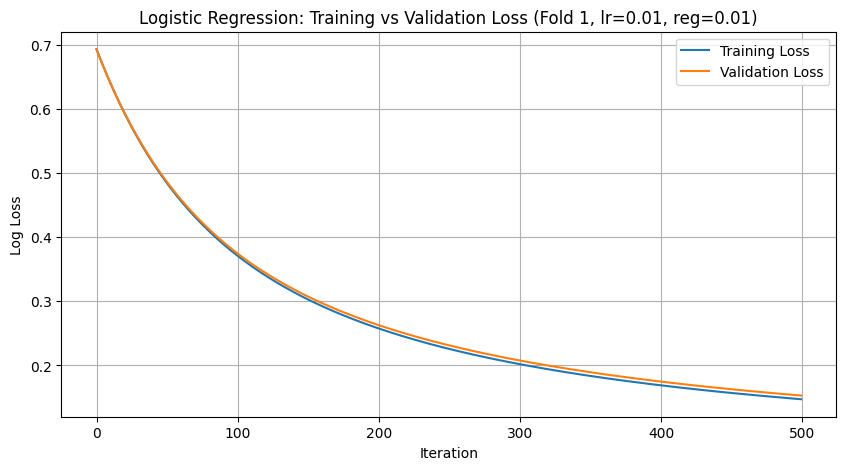

In [17]:
# Plot loss curves (add this after the above)
if plot_train_losses is not None and plot_val_losses is not None:
    plt.figure(figsize=(10, 5))
    plt.plot(plot_train_losses, label='Training Loss')
    plt.plot(plot_val_losses, label='Validation Loss')
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')
    plt.title('Logistic Regression: Training vs Validation Loss (Fold 1, lr=0.01, reg=0.01)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("\n⚠ Warning: Loss curves not saved. Check loop indentation and hyperparameter values.")

**Question 2:** Why do we use the sigmoid function in Logistic Regression? (4 points, 4-5 sentences)

The sigmoid function turns any number into a value between 0 and 1, which we can interpret as a probability. This is perfect for binary classification, where we want to say “there’s a 70% chance this is class 1.” It’s also smooth and differentiable, so we can use gradient descent to train the model. Without it, predictions could be any number (like -5 or 100), which doesn’t make sense for probabilities.

---

# Task 3: Decision Tree (30 points)

Implement a Decision Tree classifier using information gain (entropy) for multi-class classification of all three Iris species.

**Hyperparameters to tune:**
- Maximum depth: `[3, 5, 10]`
- Minimum samples to split: `[2, 5, 10]`

## 3.1: Implement DecisionTree Class (20 points)

In [18]:
class DecisionTreeNode:
    """A node in the decision tree."""
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, value=None):
        # Internal node: stores split rule (feature + threshold) and children
        # Leaf node: stores predicted class (value)
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value  # Only set for leaf nodes

    def is_leaf(self):
        """Check if this node is a leaf."""
        return self.value is not None


class DecisionTree:
    """Decision Tree classifier using information gain (entropy)."""

    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1):
        """
        Initialise the Decision Tree.

        What we do:
        - Store hyperparameters that control tree growth
        - These prevent overfitting by limiting complexity
        """
        # TODO: Store hyperparameters (1 point)
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.root = None  # Will hold the root node after training

    def _entropy(self, y):
        """
        Compute entropy of a label array.
        Entropy = -sum(p * log2(p)) for each class
        """
        # TODO: Implement entropy calculation (2 points)
        # Steps:
        # 1. Count how many samples belong to each class
        # 2. Convert counts to probabilities (p = count / total)
        # 3. Compute -sum(p * log2(p)) — but skip p=0 (since 0*log(0) = 0)
        if len(y) == 0:
            return 0.0

        # Count occurrences of each class
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)

        # Filter out zero probabilities to avoid log(0)
        probabilities = probabilities[probabilities > 0]

        # Compute entropy: -Σ p * log2(p)
        entropy = -np.sum(probabilities * np.log2(probabilities))
        return entropy

    def _information_gain(self, y, y_left, y_right):
        """
        Compute information gain from a split.
        IG = entropy(parent) - weighted_avg(entropy(children))
        """
        # TODO: Implement information gain (2 points)
        # Steps:
        # 1. Compute entropy of parent node (before split)
        # 2. Compute entropy of left and right children
        # 3. Weight each child's entropy by its proportion of samples
        # 4. IG = parent_entropy - (weighted_avg_child_entropy)
        parent_entropy = self._entropy(y)

        # If either child is empty, no useful split
        if len(y_left) == 0 or len(y_right) == 0:
            return 0.0

        # Weighted average entropy of children
        n_total = len(y)
        n_left, n_right = len(y_left), len(y_right)
        weighted_entropy = (n_left / n_total) * self._entropy(y_left) + \
                          (n_right / n_total) * self._entropy(y_right)

        return parent_entropy - weighted_entropy

    def _best_split(self, X, y):
        """
        Find the best feature and threshold to split on.
        """
        # TODO: Implement best split search (5 points)
        # Strategy:
        # - Try every feature
        # - For each feature, try every unique value as a threshold
        # - For each (feature, threshold):
        #     a. Split data: left (<= threshold), right (> threshold)
        #     b. Check min_samples_leaf constraint on both sides
        #     c. Compute information gain
        #     d. Track the split with highest gain
        best_gain = 0.0
        best_feature_idx = None
        best_threshold = None
        n_features = X.shape[1]

        # Loop over all features
        for feature_idx in range(n_features):
            # Get all unique values for this feature as candidate thresholds
            thresholds = np.unique(X[:, feature_idx])

            # Try each threshold
            for threshold in thresholds:
                # Split data based on threshold
                left_mask = X[:, feature_idx] <= threshold
                y_left = y[left_mask]
                y_right = y[~left_mask]

                # Enforce minimum samples in each leaf (prevent tiny leaves)
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue

                # Compute information gain for this split
                gain = self._information_gain(y, y_left, y_right)

                # Keep track of best split so far
                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold, best_gain

    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.
        """
        # TODO: Implement recursive tree building (6 points)
        # Stopping conditions (when to make a leaf):
        # 1. Max depth reached
        # 2. All samples have same label (pure node)
        # 3. Not enough samples to split
        n_samples = len(y)
        n_classes = len(np.unique(y))

        # Check stopping conditions
        if (depth >= self.max_depth or
            n_classes == 1 or
            n_samples < self.min_samples_split):
            # Make leaf: predict majority class
            leaf_value = Counter(y).most_common(1)[0][0]
            return DecisionTreeNode(value=leaf_value)

        # Find best split
        feature_idx, threshold, gain = self._best_split(X, y)

        # If no valid split found (gain=0), make leaf
        if gain == 0:
            leaf_value = Counter(y).most_common(1)[0][0]
            return DecisionTreeNode(value=leaf_value)

        # Split data
        left_mask = X[:, feature_idx] <= threshold
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[~left_mask], y[~left_mask]

        # Recursively build left and right subtrees
        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)

        # Return internal node with split info
        return DecisionTreeNode(
            feature_idx=feature_idx,
            threshold=threshold,
            left=left_child,
            right=right_child
        )

    def fit(self, X, y):
        """
        Train the decision tree.
        """
        # TODO: Build the tree (2 points)
        # Just call the recursive builder starting at root (depth=0)
        self.root = self._build_tree(X, y)
        return self

    def _predict_sample(self, x, node):
        """
        Predict class for a single sample by traversing the tree.
        """
        # TODO: Traverse tree to make prediction (1 point)
        # If current node is leaf → return its value
        # Else → go left or right based on feature comparison
        if node.is_leaf():
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)

    def predict(self, X):
        """
        Make predictions for all samples.
        """
        # TODO: Predict for each sample (1 point)
        # Apply _predict_sample to every row in X
        return np.array([self._predict_sample(x, self.root) for x in X])

## 3.2: 5-Fold Cross-Validation for Decision Tree (10 points)

**Steps:**
1. Prepare data: Multi-class classification (all 3 classes)
2. For each fold:
   - Split train into train_inner and validation (80%-20%)
   - Grid search over hyperparameters using validation set
   - Train final model with best hyperparameters on full train set
   - Evaluate on test set
3. Report results with mean, std, and 95% CI
4. Plot validation accuracy for different max_depth values

In [19]:
# Prepare data for Decision Tree
# Multi-class classification: all 3 classes
X_tree = X_full.copy()
y_tree = y_full.copy()

print(f"Decision Tree Data:")
print(f"  X shape: {X_tree.shape}")
print(f"  y shape: {y_tree.shape}")
print(f"  Classes: {list(iris.target_names)}")

# Hyperparameter grid
max_depths = [3, 5, 10]
min_samples_splits = [2, 5, 10]  # Correct name: min_samples_split (not min_samples_leafs)

# Storage for results
accuracy_scores = []
precision_scores_list = []
recall_scores_list = []
f1_scores_list = []
best_params_per_fold = []

# For plotting: track validation accuracy for each max_depth (average over all min_samples_split)
depth_val_accuracies = {d: [] for d in max_depths}

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

print("\n" + "="*60)
print("DECISION TREE: 5-FOLD CROSS-VALIDATION")
print("="*60)

for fold_num, (train_idx, test_idx) in enumerate(kf.split(X_tree), 1):
    print(f"\n--- Fold {fold_num} ---")

    # Split into train (80%) and test (20%)
    X_train_full, X_test = X_tree[train_idx], X_tree[test_idx]
    y_train_full, y_test = y_tree[train_idx], y_tree[test_idx]

    # TODO: Further split train into train_inner and validation (80%-20%)
    X_train_inner, X_val, y_train_inner, y_val = train_test_split(
        X_train_full, y_train_full,
        test_size=0.2,
        random_state=seed,
        stratify=y_train_full  # Preserve class distribution
    )

    # Track best performance
    best_accuracy = -1
    best_params = None

    # For tracking accuracy per max_depth (for plotting)
    depth_accuracies_temp = {d: [] for d in max_depths}

    # TODO: Grid search over hyperparameters (5 points)
    for max_d in max_depths:
        for min_split in min_samples_splits:
            # Create and train model
            model = DecisionTree(
                max_depth=max_d,
                min_samples_split=min_split,
                min_samples_leaf=1  # Keep leaf size fixed at 1 (as per class default)
            )
            model.fit(X_train_inner, y_train_inner)

            # Evaluate on validation set
            val_pred = model.predict(X_val)
            val_acc = accuracy_score(y_val, val_pred)

            # Track for best model
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = (max_d, min_split)

            # Track for plotting: group by max_depth
            depth_accuracies_temp[max_d].append(val_acc)

    # Average validation accuracy per max_depth (for plotting)
    for d in max_depths:
        if depth_accuracies_temp[d]:  # Avoid empty lists
            depth_val_accuracies[d].append(np.mean(depth_accuracies_temp[d]))

    print(f"  Best hyperparameters: max_depth={best_params[0]}, min_samples_split={best_params[1]} | Val Acc: {best_accuracy:.4f}")
    best_params_per_fold.append(best_params)

    # TODO: Train final model with best parameters on full training set (1 point)
    final_model = DecisionTree(
        max_depth=best_params[0],
        min_samples_split=best_params[1],
        min_samples_leaf=1
    )
    final_model.fit(X_train_full, y_train_full)

    # TODO: Evaluate on test set and store results (1 point)
    test_pred = final_model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, test_pred))
    precision_scores_list.append(precision_score(y_test, test_pred, average='macro'))
    recall_scores_list.append(recall_score(y_test, test_pred, average='macro'))
    f1_scores_list.append(f1_score(y_test, test_pred, average='macro'))

# TODO: Print final results with mean, std, and 95% CI for all metrics (1 point)
print("\n" + "="*60)
print("DECISION TREE: FINAL RESULTS")
print("="*60)
print_results("Accuracy", accuracy_scores)
print_results("Precision (macro)", precision_scores_list)
print_results("Recall (macro)", recall_scores_list)
print_results("F1-Score (macro)", f1_scores_list)

Decision Tree Data:
  X shape: (150, 4)
  y shape: (150,)
  Classes: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]

DECISION TREE: 5-FOLD CROSS-VALIDATION

--- Fold 1 ---
  Best hyperparameters: max_depth=3, min_samples_split=2 | Val Acc: 0.9583

--- Fold 2 ---
  Best hyperparameters: max_depth=3, min_samples_split=2 | Val Acc: 0.9583

--- Fold 3 ---
  Best hyperparameters: max_depth=3, min_samples_split=2 | Val Acc: 1.0000

--- Fold 4 ---
  Best hyperparameters: max_depth=3, min_samples_split=2 | Val Acc: 1.0000

--- Fold 5 ---
  Best hyperparameters: max_depth=3, min_samples_split=2 | Val Acc: 0.8333

DECISION TREE: FINAL RESULTS
Accuracy: 0.9600 ± 0.0435 (95% CI: [0.9060, 1.0140])
Precision (macro): 0.9629 ± 0.0406 (95% CI: [0.9125, 1.0134])
Recall (macro): 0.9633 ± 0.0400 (95% CI: [0.9137, 1.0130])
F1-Score (macro): 0.9612 ± 0.0421 (95% CI: [0.9089, 1.0134])


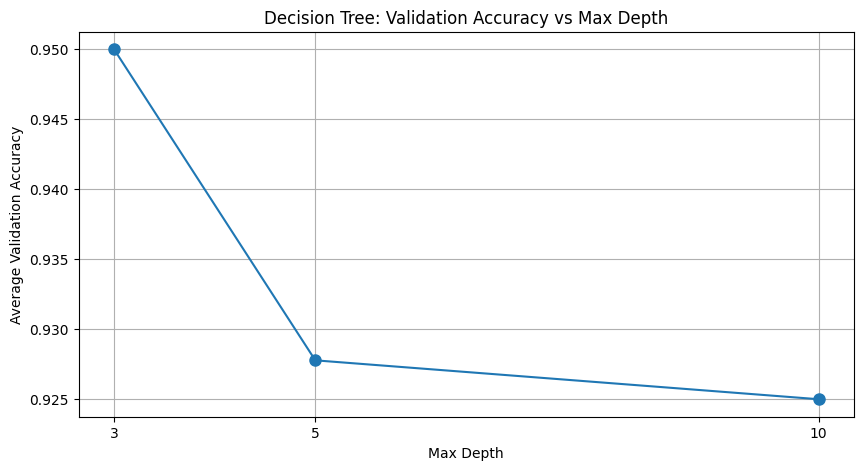

In [20]:
# Plot validation accuracy vs max_depth
plt.figure(figsize=(10, 5))
mean_acc_per_depth = [np.mean(depth_val_accuracies[d]) for d in max_depths]
plt.plot(max_depths, mean_acc_per_depth, marker='o', linestyle='-', markersize=8)
plt.xlabel('Max Depth')
plt.ylabel('Average Validation Accuracy')
plt.title('Decision Tree: Validation Accuracy vs Max Depth')
plt.grid(True)
plt.xticks(max_depths)
plt.show()

**Question 3:** What are the risks of having a tree that is too shallow or too deep? (4 points, 4-5 sentences)

A tree that’s too shallow can’t capture complex patterns in the data, leading to underfitting—it’s like using only one rule to diagnose all diseases. A tree that’s too deep memorizes noise in the training data, causing overfitting—it works perfectly on known examples but fails on new ones. Deep trees are also harder to understand and slower to use. The goal is to find the right depth that balances simplicity and accuracy.

---

# Convert Your Colab Notebook to PDF

### Step 1: Download Your Notebook
- Go to **File → Download → Download .ipynb**
- Save the file to your computer

### Step 2: Upload to Colab
- Click the **📁 folder icon** on the left sidebar
- Click the **upload button**
- Select your downloaded .ipynb file
- Wait for the upload to complete

### Step 3: Run the Code Below
- **Uncomment the cell below** and run the cell
- This will take about 1-2 minutes to install required packages

### Step 4: Enter Notebook Name
- When prompted, type your notebook name (e.g., `gs_000000_project.ipynb`)
- Press Enter

### The PDF will automatically download to your computer

In [23]:
# Install required packages (this takes about 30 seconds)
print("Installing PDF converter... please wait...")
!apt-get update -qq
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc > /dev/null 2>&1
!pip install -q nbconvert

print("\n" + "="*50)
print("COLAB NOTEBOOK TO PDF CONVERTER")
print("="*50)
print("\nSTEP 1: Download your notebook")
print("- Go to File → Download → Download .ipynb")
print("- Save it to your computer")
print("\nSTEP 2: Upload it here")
print("- Click the folder icon on the left (📁)")
print("- Click the upload button and select your .ipynb file")
print("- Wait for upload to complete")
print("\nSTEP 3: Enter the filename below")
print("="*50)

# Get notebook name from user
notebook_name = input("\nEnter your notebook name: ")

# Add .ipynb if missing
if not notebook_name.endswith('.ipynb'):
    notebook_name += '.ipynb'

import os
notebook_path = f'/content/{notebook_name}'

# Check if file exists
if not os.path.exists(notebook_path):
    print(f"\n⚠ Error: '{notebook_name}' not found in /content/")
    print("\nMake sure you uploaded the file using the folder icon (📁) on the left!")
else:
    print(f"\n✔ Found {notebook_name}")
    print("Converting to PDF... this may take 1-2 minutes...\n")

    # Convert the notebook to PDF
    !jupyter nbconvert --to pdf "{notebook_path}"

    # Download the PDF
    from google.colab import files
    pdf_name = notebook_name.replace('.ipynb', '.pdf')
    pdf_path = f'/content/{pdf_name}'

    if os.path.exists(pdf_path):
        print("✔ SUCCESS! Downloading your PDF now...")
        files.download(pdf_path)
        print("\n✔ Done! Check your downloads folder.")
    else:
        print("⚠ Error: Could not create PDF")

Installing PDF converter... please wait...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)

COLAB NOTEBOOK TO PDF CONVERTER

STEP 1: Download your notebook
- Go to File → Download → Download .ipynb
- Save it to your computer

STEP 2: Upload it here
- Click the folder icon on the left (📁)
- Click the upload button and select your .ipynb file
- Wait for upload to complete

STEP 3: Enter the filename below

Enter your notebook name: AINE431_TERM_PROJECT.ipynb

✔ Found AINE431_TERM_PROJECT.ipynb
Converting to PDF... this may take 1-2 minutes...

[NbConvertApp] Converting notebook /content/AINE431_TERM_PROJECT.ipynb to pdf
[NbConvertApp] Support files will be in AINE431_TERM_PROJECT_files/
[NbConvertApp] Making directory ./AINE431_TERM_PROJECT_files
[NbConvertApp] Writing 116140 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running x

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✔ Done! Check your downloads folder.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')